In [1]:
import glob
import os
import pprint
import traceback
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [2]:
def tflog2pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame
    Parameters
    ----------
    path : str
        path to tensorflow log file
    Returns
    -------
    pd.DataFrame
        converted dataframe
    """
    DEFAULT_SIZE_GUIDANCE = {
        'compressedHistograms': 1,
        'images': 1,
        'scalars': 0,  # 0 means load all
        'histograms': 1,
    }
    runlog_data = pd.DataFrame({'metric': [], 'value': [], 'step': []})
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()['scalars']
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {'metric': [tag] * len(step), 'value': values, 'step': step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print('Event file possibly corrupt: {}'.format(path))
        traceback.print_exc()
    return runlog_data

In [3]:
# find TB logfiles in path
path = './data'
param1_log_paths = glob.glob(os.path.join(path, 'algo_1/*'))
param2_log_paths = glob.glob(os.path.join(path, 'algo_2/*'))
param2_log_paths

['./data/algo_2/events.out.tfevents.1619191258.aki.2872.0',
 './data/algo_2/events.out.tfevents.1619191321.aki.3152.0']

In [4]:
# create dataframes from TB logs
param1_logs = pd.DataFrame()
for path in param1_log_paths:
    log = tflog2pandas(path)
    if log is not None:
        if param1_logs.shape[0] == 0:
            param1_logs = log
        else:
            param1_logs = param1_logs.append(log, ignore_index=True)
            
param2_logs = pd.DataFrame()
for path in param2_log_paths:
    log = tflog2pandas(path)
    if log is not None:
        if param2_logs.shape[0] == 0:
            param2_logs = log
        else:
            param2_logs = param2_logs.append(log, ignore_index=True)

In [5]:
# query episode rewards (rollout/ep_rew_mean)
# limit steps to 1000000
agg_param1_logs = param1_logs.query('metric == "rollout/ep_rew_mean" & step <= 1000000').copy()
agg_param1_logs = agg_param1_logs.reset_index()
agg_param1_logs['type'] = 'algo_1'

# query episode rewards (eval/mean_episode_reward)
# limit steps to 1000000
agg_param2_logs = param2_logs.query('metric == "eval/mean_episode_reward" & step <= 1000000').copy()
agg_param2_logs = agg_param2_logs.reset_index()
agg_param2_logs['type'] = 'algo_2'

# join log files
joint_logs = pd.DataFrame()
joint_logs = joint_logs.append(agg_param1_logs)
joint_logs = joint_logs.append(agg_param2_logs)
joint_logs.head()

,index,metric,value,step,type
0,36930,rollout/ep_rew_mean,61.000000,250.0,algo_1
1,36931,rollout/ep_rew_mean,43.500000,500.0,algo_1
2,36932,rollout/ep_rew_mean,72.333336,750.0,algo_1
3,36933,rollout/ep_rew_mean,121.250000,1000.0,algo_1
4,36934,rollout/ep_rew_mean,97.000000,1250.0,algo_1


(-50.0, 1050.0)

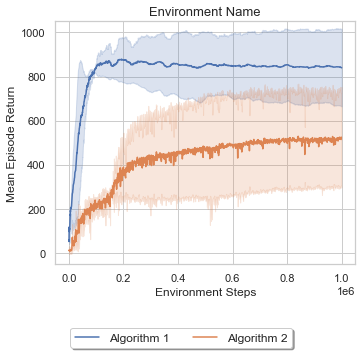

In [8]:
# create figure (one plot)
fig = plt.figure(figsize=(5.5, 4.5))
fig.patch.set_facecolor('white')

# set style and context
sns.set(style='whitegrid')
sns.set_context("notebook")

# create graph
graph = sns.lineplot(data=joint_logs, 
                     x='step', 
                     y='value', 
                     hue='type', 
                     ci='sd')

# set legend options
handles, labels = graph.get_legend_handles_labels()
labels = ['Algorithm 1', 'Algorithm 2']
fig.tight_layout(pad=2.0)
fig.legend(loc='lower center', 
           bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, 
           shadow=True, 
           ncol=5, 
           prop={'size': 12}, 
           labels=labels)

# graph options
graph.legend([],[], frameon=False)
graph.set(xlabel='Environment Steps', ylabel='Mean Episode Return')
graph.title.set_text('Environment Name')
graph.title.set_size(13)
graph.set_ylim(-50, 1050)

(-50.0, 1050.0)

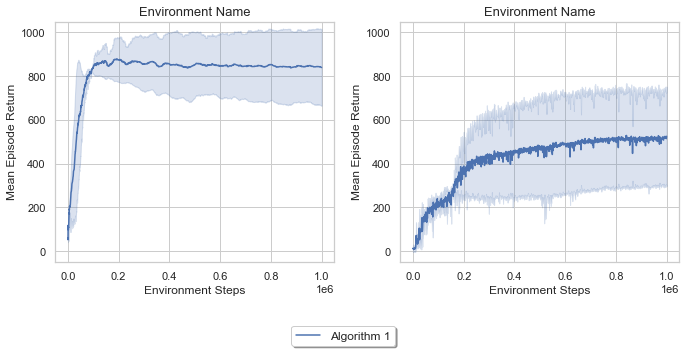

In [7]:
# create figure (multiple plots)
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4.5))

# set style and context
sns.set(style='whitegrid')
sns.set_context("notebook")

# create first graph
graph1 = sns.lineplot(data=agg_param1_logs, 
                      x='step', 
                      y='value', 
                      hue='type', 
                      ci='sd', 
                      ax=axs[0], 
                      legend="full")

# create second graph
graph2 = sns.lineplot(data=agg_param2_logs, 
                      x='step', 
                      y='value', 
                      hue='type', 
                      ci='sd', 
                      ax=axs[1], 
                      legend=None)


handles, labels = graph1.get_legend_handles_labels()
labels = ['Algorithm 1']
fig.tight_layout(pad=2.0)
fig.legend(loc='lower center', 
           bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, 
           shadow=True, 
           ncol=5, 
           prop={'size': 12}, 
           labels=labels)

# graph options
graph1.legend([],[], frameon=False)
graph1.set(xlabel='Environment Steps', ylabel='Mean Episode Return')
graph2.set(xlabel='Environment Steps', ylabel='Mean Episode Return')
graph1.title.set_text('Environment Name')
graph2.title.set_text('Environment Name')
graph1.title.set_size(13)
graph2.title.set_size(13)
graph1.set_ylim(-50, 1050)
graph2.set_ylim(-50, 1050)